In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
import umap

## 2D regression dataset

In [4]:
num_points = 50
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

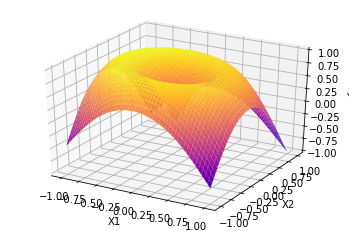

In [5]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
#         invA = A.t()
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [7]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Distance Embedding of the data

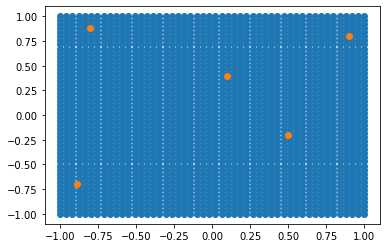

In [8]:
centers = torch.Tensor([[0.9, 0.8],
                        [-0.8, 0.88],
                        [-0.89, -0.7],
                        [0.1, 0.4],
                        [0.5, -0.2]])
plt.scatter(x1, x2)
plt.scatter(*centers.t())

### Find the mapping of centers along with activation

In [9]:
import dtnnlib as dtnn

In [10]:
# dt = dtnn.DistanceTransform_MinExp(2, num_centers=5)
dt = dtnn.DistanceTransform_Exp(2, num_centers=5)

dt.centers.data = centers
dt(xx).shape

torch.Size([2500, 5])

In [11]:
## check how it works as embedding for neural network

In [12]:
net = nn.Sequential(
                   dt,
                   nn.Linear(5, 10),
                   nn.LeakyReLU(),
                   nn.Linear(10, 1),
                   )
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

Step: 0, error: 0.559972
Step: 100, error: 0.067412
Step: 200, error: 0.024325
Step: 300, error: 0.021357
Step: 400, error: 0.020278
Step: 500, error: 0.019571
Step: 600, error: 0.018807
Step: 700, error: 0.017841
Step: 800, error: 0.016451
Step: 900, error: 0.013752
Step: 1000, error: 0.002497
Step: 1100, error: 0.001540
Step: 1200, error: 0.001319
Step: 1300, error: 0.001213
Step: 1400, error: 0.001147
Step: 1500, error: 0.001192
Step: 1600, error: 0.001073
Step: 1700, error: 0.001019
Step: 1800, error: 0.000988
Step: 1900, error: 0.000960
Step: 2000, error: 0.000954
Step: 2100, error: 0.000917
Step: 2200, error: 0.000895
Step: 2300, error: 0.000877
Step: 2400, error: 0.000873
Step: 2500, error: 0.000868
Step: 2600, error: 0.000828
Step: 2700, error: 0.000843
Step: 2800, error: 0.000794
Step: 2900, error: 0.000775
Step: 3000, error: 0.000769
Step: 3100, error: 0.000752
Step: 3200, error: 0.000736
Step: 3300, error: 0.000726
Step: 3400, error: 0.000747
Step: 3500, error: 0.000704
Step

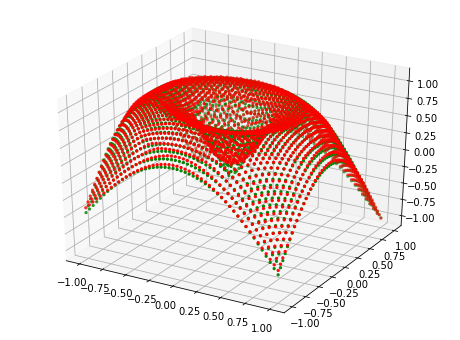

In [13]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

EPOCHS = 4000
for i in range(EPOCHS):
    yout = net(xx)
    error = criterion(yout, yy)
    
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(x1, x2, y, c='g', marker='.')
        ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

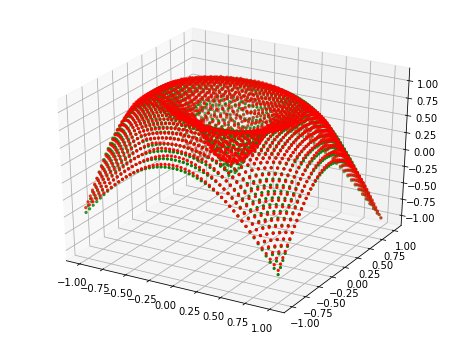

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.clear()
ax.scatter(x1, x2, y, c='g', marker='.')
ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')

plt.show()

### Now embedding using UMAP

In [15]:
embedder = umap.UMAP(n_neighbors=3, n_components=2, min_dist=0.1, spread=1, metric="euclidean")

In [16]:
embedding = embedder.fit_transform(dt.centers.data.cpu().numpy())
embedding

array([[11.754789, 21.87097 ],
       [11.205751, 21.27034 ],
       [ 9.808343, 22.041647],
       [10.928882, 22.425852],
       [10.230878, 22.759089]], dtype=float32)

In [17]:
emb = embedding - embedding.mean(axis=0, keepdims=True)
emb

array([[ 0.9690609 , -0.20261002],
       [ 0.42002296, -0.8032398 ],
       [-0.9773855 , -0.03193283],
       [ 0.14315319,  0.35227203],
       [-0.5548506 ,  0.6855087 ]], dtype=float32)

(-2.491121363639831, 2.577807974815368, -2.753110587596893, 2.871624410152435)

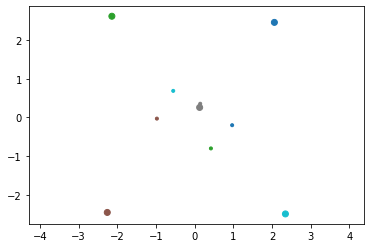

In [18]:
%matplotlib inline
plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.axis('equal')

In [19]:
activs = dt(xx).data.numpy()

In [20]:
i = 40

(-1.0747078418731688,
 1.0663832187652587,
 -0.8776772499084471,
 0.7599461555480955)

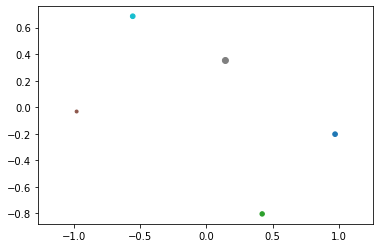

In [21]:
activ = activs[i]
i += 1

# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), s=np.maximum(activ*80, 0.01), marker='+',cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), s=np.maximum(activ*80, 0.01), cmap="tab10")
plt.axis('equal')

In [22]:
### Use the embedding to select Top-K neurons 

In [23]:
# class SpatialAttention(nn.Module):
    
#     def __init__(self, num_inputs, num_outputs, input_embedding, num_neighbour):
#         super().__init__()
#         self.num_inputs = num_inputs
#         self.num_outputs = num_outputs
#         self.num_neighbour = num_neighbour
#         self.input_embedding = torch.Tensor(input_embedding)
# #         self.input_embedding = nn.Parameter(self.input_embedding)
        
#         embd_dim = input_embedding.shape[1]
#         self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim))
#         self.W = None
        
#         lin = nn.Linear(num_inputs, num_outputs)
#         self.weights = nn.Parameter(lin.weight.data.t())
#         self.bias = nn.Parameter(lin.bias.data)
        
#         self.hardness = 1
        
#     def forward(self, x):
#         self.weights.data = torch.clamp(self.weights.data, -2, 2)
#         ## take winning neuron for selecting neighbours
#         winner = x.argmax(dim=1)
# #         print(winner.shape)


#         #### take distance between embeddings
#         edist = torch.cdist(self.input_embedding, self.output_embedding)
        
#         #### first scale distance to generalized gaussian to select K-nearest neighbours
#         A = self.hardness

#         topk_edist, _ = torch.topk(edist, k=self.num_neighbour, dim=1, largest=False, sorted=True)
#         edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
#         b = 1/edge_dist + 1e-5
#         scaler = torch.exp(-(edist**2 * b**2)**A)
        
# #         topk_edist1, _ = torch.topk(edist, k=self.num_neighbour, dim=0, largest=False, sorted=True)
# #         edge_dist1 = topk_edist1[-1:]
# #         b1 = 1/edge_dist1 + 1e-5
# #         scaler1 = torch.exp(-(edist**2 * b1**2)**A)
# #         scaler = scaler1
        
# #         scaler = (scaler + scaler1)/2
        
#         self.W = scaler
#         KM = scaler[winner]
        
#         ## use this to scale the weights
#         ytemp = torch.matmul(x, self.weights)
#         y = ytemp*KM + self.bias
#         return y

In [24]:
class SpatialAttention(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, input_embedding, out_neighbours, inp_neighbours):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.out_neighbours = out_neighbours
        self.inp_neighbours = inp_neighbours
        
        self.input_embedding = torch.Tensor(input_embedding)
#         self.input_embedding = nn.Parameter(self.input_embedding)
        
        embd_dim = input_embedding.shape[1]
        self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim)/2)
        self.W = None
        
        lin = nn.Linear(num_inputs, num_outputs)
        self.weights = nn.Parameter(lin.weight.data.t())
        self.bias = nn.Parameter(lin.bias.data)
        
        self.hardness = 0.25
        
    def forward(self, x):
        self.weights.data = torch.clamp(self.weights.data, -2, 2)
        ## take winning neuron for selecting neighbours
        winner = x.argmax(dim=1)
#         print(winner.shape)


        #### take distance between embeddings
        edist = torch.cdist(self.input_embedding, self.output_embedding)
        
        #### first scale distance to generalized gaussian to select K-nearest neighbours
        A = self.hardness

        topk_edist, _ = torch.topk(edist, k=self.out_neighbours, dim=1, largest=False, sorted=True)
        edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
        b = 1/edge_dist + 1e-5
        scaler = torch.exp(-(edist**2 * b**2)**A)
        
        topk_edist1, _ = torch.topk(edist, k=self.inp_neighbours, dim=0, largest=False, sorted=True)
        edge_dist1 = topk_edist1[-1:]
        b1 = 1/edge_dist1 + 1e-5
        scaler1 = torch.exp(-(edist**2 * b1**2)**A)
        
        
        self.W = scaler
        self.W1 = scaler1
        
        KM = scaler[winner]
        
        ## use this to scale the weights
        ytemp = torch.matmul(x, self.weights*scaler1)
        y = ytemp*KM + self.bias
        return y

In [25]:
sa = SpatialAttention(5, 6, emb, out_neighbours=5, inp_neighbours=3)

In [26]:
sa(dt(xx))

tensor([[-1.1686e-01,  4.5301e-01, -5.2137e-02, -4.1249e-02,  1.1013e-02,
         -2.3155e-01],
        [-1.1763e-01,  4.5271e-01, -5.2422e-02, -4.1628e-02,  1.0954e-02,
         -2.3076e-01],
        [-1.1841e-01,  4.5240e-01, -5.2714e-02, -4.2009e-02,  1.0893e-02,
         -2.2996e-01],
        ...,
        [-1.3399e-01,  4.2442e-01, -7.8015e-02, -3.3122e-02,  8.3886e-04,
         -2.2487e-01],
        [-1.3421e-01,  4.2342e-01, -7.8220e-02, -3.2436e-02,  4.4924e-04,
         -2.2540e-01],
        [-1.3443e-01,  4.2243e-01, -7.8424e-02, -3.1752e-02,  6.9808e-05,
         -2.2592e-01]], grad_fn=<AddBackward0>)

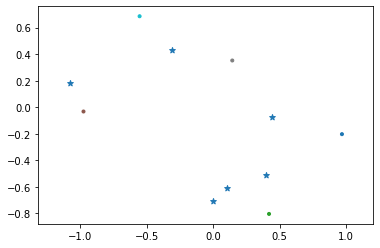

In [27]:
%matplotlib inline
# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sa.output_embedding.data.t(), marker='*')
plt.axis('equal')
plt.show()

### Forward propagate using the Spatial Attention

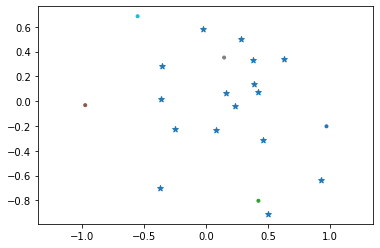

In [54]:
N = 16
sa = SpatialAttention(5, N, emb, out_neighbours=5, inp_neighbours=3)

%matplotlib inline
plt.scatter(*sa.input_embedding.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sa.output_embedding.data.t(), marker='*')
plt.axis('equal')
plt.show()


sanet = nn.Sequential(
        sa,
        nn.LeakyReLU(0.1),
        nn.Linear(N, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sanet.parameters(), lr=0.01)

Step: 0, error: 0.376307
Step: 100, error: 0.091680
Step: 200, error: 0.054568
Step: 300, error: 0.051664
Step: 400, error: 0.051314
Step: 500, error: 0.051019
Step: 600, error: 0.050703
Step: 700, error: 0.046722
Step: 800, error: 0.044000
Step: 900, error: 0.028850
Step: 1000, error: 0.024792
Step: 1100, error: 0.023453
Step: 1200, error: 0.013094
Step: 1300, error: 0.022022
Step: 1400, error: 0.019980
Step: 1500, error: 0.019143
Step: 1600, error: 0.018153
Step: 1700, error: 0.016585
Step: 1800, error: 0.012787
Step: 1900, error: 0.010413
Step: 2000, error: 0.004168
Step: 2100, error: 0.017198
Step: 2200, error: 0.015626
Step: 2300, error: 0.014865
Step: 2400, error: 0.014279
Step: 2500, error: 0.013643
Step: 2600, error: 0.012960
Step: 2700, error: 0.012231
Step: 2800, error: 0.011460
Step: 2900, error: 0.010516
Step: 3000, error: 0.009747
Step: 3100, error: 0.009064
Step: 3200, error: 0.008469
Step: 3300, error: 0.007952
Step: 3400, error: 0.007509
Step: 3500, error: 0.007135
Step

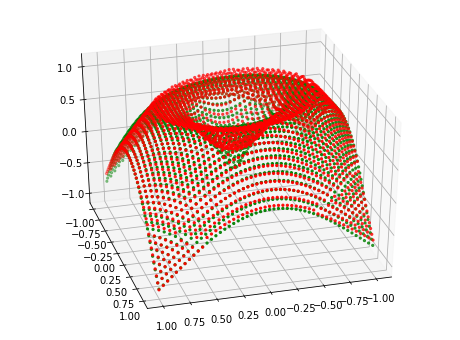

In [55]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

EPOCHS = 5000*2
for i in range(EPOCHS):
    yout = sanet(dt(xx))
    error = criterion(yout, yy)
    
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    
#     if i < 3000:
#         sa.input_embedding.grad *= 0

    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(x1, x2, y, c='g', marker='.')
        ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
    if i>0 and i%2000 == 0:
        sa.hardness *= 2

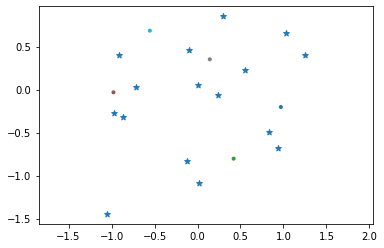

In [56]:
%matplotlib inline
# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*sa.input_embedding.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sa.output_embedding.data.t(), marker='*')
plt.axis('equal')
plt.show()

In [57]:
sa.W

tensor([[1.9517e-28, 0.0000e+00, 0.0000e+00, 4.7614e-02, 9.7209e-01, 8.4184e-01,
         2.5384e-38, 6.4671e-01, 0.0000e+00, 3.6786e-01, 0.0000e+00, 9.9880e-01,
         4.9295e-28, 6.1137e-05, 1.4558e-28, 0.0000e+00],
        [9.3686e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.4982e-01, 7.9810e-06,
         9.6641e-01, 0.0000e+00, 0.0000e+00, 3.6786e-01, 0.0000e+00, 9.5573e-01,
         0.0000e+00, 2.7351e-03, 0.0000e+00, 0.0000e+00],
        [2.2569e-02, 2.5567e-08, 9.9999e-01, 0.0000e+00, 0.0000e+00, 4.6703e-16,
         7.6100e-10, 0.0000e+00, 9.9841e-01, 6.6092e-03, 9.9997e-01, 0.0000e+00,
         4.5090e-16, 3.6785e-01, 3.1931e-01, 9.9991e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2039e-45, 0.0000e+00, 8.2735e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 8.1945e-01, 4.6209e-41, 0.0000e+00,
         3.6786e-01, 9.7687e-01, 9.9553e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0802e-02, 0.0000e+00, 0.0000e+00, 1.2620e-06,
         0.0000e+00, 0.0000e+00, 9.9405

In [66]:
sanet[1](sanet[0](dt(xx))[0])

tensor([-0.0272,  0.1763, -0.0147,  0.5893, -0.0030,  0.3218,  0.2223, -0.0074,
        -0.0179,  0.3673, -0.0211, -0.0202,  0.2758, -0.0608, -0.0566, -0.0298],
       grad_fn=<LeakyReluBackward0>)

In [59]:
line_collection = []
weight_collection = []

# saW = sa.W*sa.weights
saW = sa.W

for i, inp in enumerate(sa.input_embedding):
    p0 = tuple(inp.tolist())
    for j, out in enumerate(sa.output_embedding):
        p1 = tuple(out.tolist())
        
        line_collection.append([p0,p1])
        weight_collection.append(float(saW[i,j]))
#         break
        
line_collection, weight_collection = np.array(line_collection), np.array(weight_collection)

In [60]:
line_collection

array([[[ 0.9690609 , -0.20261002],
        [-0.12074073, -0.82908994]],

       [[ 0.9690609 , -0.20261002],
        [-1.05728638, -1.44628894]],

       [[ 0.9690609 , -0.20261002],
        [-0.96775049, -0.27090335]],

       [[ 0.9690609 , -0.20261002],
        [ 1.02408171,  0.65495241]],

       [[ 0.9690609 , -0.20261002],
        [ 0.93079126, -0.67997426]],

       [[ 0.9690609 , -0.20261002],
        [ 0.54782844,  0.22469696]],

       [[ 0.9690609 , -0.20261002],
        [ 0.0119272 , -1.09096754]],

       [[ 0.9690609 , -0.20261002],
        [ 1.25431824,  0.40800631]],

       [[ 0.9690609 , -0.20261002],
        [-0.91385955,  0.40638947]],

       [[ 0.9690609 , -0.20261002],
        [ 0.23418127, -0.06482692]],

       [[ 0.9690609 , -0.20261002],
        [-0.71920508,  0.03082235]],

       [[ 0.9690609 , -0.20261002],
        [ 0.83652663, -0.49678889]],

       [[ 0.9690609 , -0.20261002],
        [ 0.29121286,  0.8531816 ]],

       [[ 0.9690609 , -0.20261002],
  

In [61]:
weight_collection

array([1.88951314e-28, 0.00000000e+00, 0.00000000e+00, 4.76119146e-02,
       9.72070098e-01, 8.41947436e-01, 2.48112028e-38, 6.46700561e-01,
       0.00000000e+00, 3.67857516e-01, 0.00000000e+00, 9.98797953e-01,
       4.93213903e-28, 6.10883217e-05, 1.45063680e-28, 0.00000000e+00,
       9.36778843e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.49886322e-01, 8.04366209e-06, 9.66377497e-01, 0.00000000e+00,
       0.00000000e+00, 3.67856979e-01, 0.00000000e+00, 9.55769777e-01,
       0.00000000e+00, 2.73587694e-03, 0.00000000e+00, 0.00000000e+00,
       2.25974079e-02, 2.55143213e-08, 9.99988437e-01, 0.00000000e+00,
       0.00000000e+00, 4.66886466e-16, 7.75402964e-10, 0.00000000e+00,
       9.98405039e-01, 6.60519116e-03, 9.99973238e-01, 0.00000000e+00,
       4.49776877e-16, 3.67850333e-01, 3.19341034e-01, 9.99905705e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.20389539e-45,
       0.00000000e+00, 8.27271998e-01, 0.00000000e+00, 0.00000000e+00,
      

In [62]:
weight_collection.min(), weight_collection.max()

(0.0, 0.9999884366989136)

In [63]:
from matplotlib import collections
import matplotlib as mpl

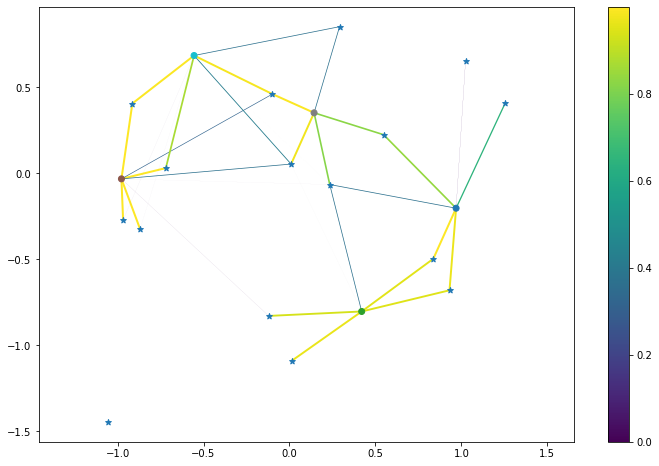

In [64]:
## plot attention weights
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# lc = collections.LineCollection(line_collection, linewidths=weight_collection*5, zorder=-2)
lc = collections.LineCollection(line_collection, 
                                array=weight_collection, 
                                linewidths= weight_collection*2, 
#                                 norm=mpl.colors.Normalize(vmin=-0, vmax=2),
#                                 cmap="PiYG", 
                                zorder=-2, )

# lc.set_array(weight_collection)
ax.add_collection(lc)
axcb = fig.colorbar(lc)

# ax.autoscale()
# ax.margins(0.1)

plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='o')
plt.scatter(*sa.output_embedding.data.t(), marker='*')

plt.axis('equal')
plt.show()

In [65]:
sa.hardness

4.0